# Monolithic Neural Network

1D two-layer neural network with sigmoid activation unit and cross-entropy loss. Includes support for:

- Minibatching
- Optional gradient checking
- L2 Regularization
- Logging so you can see what the scores, probabilities, gradients, etc. were after every minibatch

In [1]:
from collections import namedtuple

State = namedtuple('State', ['loss', 'dwhh', 'dbhh', 'dwxh', 'dbxh', 'dws', 'dbs'])
Snapshot = namedtuple('State', ['xs', 'ys', 'whh', 'bhh', 'wxh', 'bxh', 'ws', 'bs', 'dwhh', 'dbhh', 'dwxh', 'dbxh', 'dws', 'dbs', 'scores', 'loss'])

In [2]:
from softmax import softmax_2d
from nn.shallow.helper import sigmoid, sigmoid_grad

class RecurrentNeuralNetwork:
    """Initialize model parameters
    
    Additionally calculate batch index so we can use minibatches with each training iteration
    
    If you want to inspect the scores after each training example, the pass inspect. If you do
    this then you better set a batch_size to 1. Otherwise you'll only ever get the scores of
    the last training example in the minibatch
    
    """
    def __init__(self, xs_train, ys_train, whh=None, bhh=None, wxh=None, bxh=None, ws=None, bs=None,
                 learning_rate=0.001, regularizer=1., batch_size=None,
                gradient_checking=False, inspect=False):
        """Initializes monolithic neural network model
        
        Parameters
        ----------
        xs_train : list of lists. every list is a sequence of inputs for the rnn to classify
        ys_train : list of lists. every list is a sequence of labels that the rnn learns to predict
        whh : weight that multiplies the hidden term
        bhh : bias term of the hidden weight
        wxh : weight associated with input
        bxh : bias terms associated with input
        ws : list (length 2) of softmax class weights
        bs : list (length 2) of softmax class biases
        learning_rate : learning rate constant
        regularizer : regularization constant
        batch_size : size of minibatch
        gradient_checking : boolean whether to perform gradient checking during training
        inspect : boolean whether to log all data after every learning session from a training example
        
        """
        self.m, self.t = len(xs_train), len(xs_train[0])
        
        self.xs_train, self.ys_train = xs_train, ys_train
        
        # Randomly initialize weights and biases
        #
        # Hidden and input weights
        self.whh = np.random.randn() if not whh else whh
        self.bhh = np.random.randn() if not bhh else bhh
        self.wxh = np.random.randn() if not wxh else wxh
        self.bxh = np.random.randn() if not bxh else bxh
        
        # Softmax weights
        self.ws = np.array([np.random.randn(), np.random.randn()]) if not type(ws) == np.ndarray else ws
        self.bs = np.array([np.random.randn(), np.random.randn()]) if not type(bs) == np.ndarray else bs
        
        self.learning_rate = learning_rate
        self.regularizer = regularizer
        
        self.batch_size = 1 if not batch_size else batch_size
        self.batch_index = 0
        
        self.gradient_checking = gradient_checking
        self.inspect = inspect
        
        # Info from the *last* training example that was used to learn from
        self.xs, self.ys = None, None
        self.zs, self.hiddens = None, None
        self.scores, self.dscores = None, None
        self.probs = None
        self.dws, self.dbs = None, None
        self.dhiddens, self.dzs = [], None
        self.dwhh, self.dbhh = None, None
        self.dwxh, self.dbxh = None, None,
        self.loss = None
        
    def predict(self, xs):
        """Return the probability of x belonging to either class"""
        
        scores = self.forward_backward_prop(xs, predict=True)
        
        return scores, [score_pair.argmax() for score_pair in scores]
        
    def forward_backward_prop(self, xs=None, whh=None, bhh=None, wxh=None, bxh=None, ws=None, bs=None, predict=False):
        """Perform forward and backward prop over a minibatch of training examples
        
        Returns loss and gradients
        
        """
        whh = self.whh if not whh else whh
        bhh = self.bhh if not bhh else bhh
        wxh = self.wxh if not wxh else wxh
        bxh = self.bxh if not bxh else bxh
        
        ws = self.ws if not type(ws) == np.ndarray else ws
        bs = self.bs if not type(bs) == np.ndarray else bs
        
        loss, dwhh, dbhh, dwxh, dbxh, dws, dbs = 0., 0., 0., 0., 0., np.array([0.,0.]), np.array([0.,0.])
        index = self.batch_index
        
        # Perform forward-backward prop on a single sequence
        xs_train = self.xs_train if not xs else xs
        
        xs = xs_train[index]
        ys = self.ys_train[index]
        
        # Number of time steps in the sequence
        T = len(xs)
        
        # Add additional dummy terms to xs and ys to align them with natural time
        xs, ys = (None,) + xs, (None,) + ys
        
        self.hiddens = [1.]*(T+1)
        self.scores, self.probs = [0.]*(T+1), [0.]*(T+1)
        for t in range(1, T+1):
            # Forward propagation!
            #
            # Combine previous hidden layer and current input
            z = (whh*self.hiddens[t-1] + bhh) + (wxh*xs[t] + bxh)
            hidden = sigmoid(z)
            
            # Softmax
            scores = np.array([hidden,hidden])*ws + bs
            probs = softmax_2d(scores)

            # Accumulate performance loss and regularization loss
            loss += -np.log(probs[ys[t]])
            
            # Cache values for backprop
            self.hiddens[t], self.scores[t], self.probs[t] = hidden, scores, probs
            
        # Add regularization
        loss += self.regularizer * 0.5*(whh**2 + bhh**2 + wxh**2 + bxh**2 + np.sum(ws**2) + np.sum(bs**2))
            
        # Backpropagate!
        dhidden_prev = 0.
        backwards = list(reversed(range(T+1)))
        for t in backwards[:-1]:
            # Cross entropy and softmax
            dloss = 1
            dscores = self.probs[t]
            dscores[ys[t]] -= 1

            # Softmax weight gradients
            dbs += dscores
            dws += self.hiddens[t] * dscores
            
            # Most critical part of the whole optimization:
            #
            # dhidden influences to different components of the loss (i.e. the softmax at
            # time t and all future timesteps). Here we add them up and in doing so account
            # for all the ways dhidden can influence the loss!
            dhidden = sum(ws*dscores) + dhidden_prev
            
            # Sigmoid
            dz = sigmoid_grad(self.hiddens[t]) * dhidden

            # Input weights
            dbxh += dz
            dwxh += xs[t] * dz
            dx = wxh * dz # Throw this aways for now

            # Hidden weights
            dbhh += dz
            dwhh += self.hiddens[t-1] * dz

            # Set up dhidden for the next round
            dhidden_prev = whh * dz

        # Add regularization since it's being added to the loss at each time step
        #
        # Input and hidden weights
        dwhh += self.regularizer*whh
        dbhh += self.regularizer*bhh
        dwxh += self.regularizer*wxh
        dbxh += self.regularizer*bxh

        # Softmax weights
        dws += self.regularizer*ws
        dbs += self.regularizer*bs

        # Log additional info?
        if self.inspect:
            self.xs, self.ys = xs, ys
            self.dbhh = dbhh
            self.dwhh = dwhh
            self.dbxh = dbxh
            self.dwxh = dwxh
        
        return State(loss, dwhh, dbhh, dwxh, dbxh, dws, dbs)
    
    def learn(self):
        """Learn from a minibatch of training examples
        
        Have the model run forward-backward prop on these examples and average the gradients
        
        """
        loss, dwhh, dbhh, dwxh, dbxh, dws, dbs = self.forward_backward_prop()
        
        self.gradient_check(dwhh, dbhh, dwxh, dbxh, dws, dbs)
        
        # Hidden and input weights
        self.whh = self.whh - self.learning_rate*dwhh
        self.bhh = self.bhh - self.learning_rate*dbhh
        self.wxh = self.wxh - self.learning_rate*dwxh
        self.bxh = self.bxh - self.learning_rate*dbxh
        
        # Softmax weights
        self.ws = self.ws - self.learning_rate*dws
        self.bs = self.bs - self.learning_rate*dbs
        
        # Update batch index so the next time the next batch in line is used
        self.batch_index = (self.batch_index+1) % (self.m//self.batch_size)
        
        # Log additional info?
        if self.inspect:
            self.dwhh = dwhh
            self.dbhh = dbhh
            self.dwxh = dwxh
            self.dbxh = dbxh
            self.dws = dws
            self.dbs = dbs
            self.loss = loss
    
    def gradient_check(self, analytic_dwhh, analytic_dbhh, analytic_dwxh, analytic_dbxh, analytic_dws, analytic_dbs):
        """Verify gradient correctness
        
        The analytic dwhh, dbhh, dwxh, dbxh, dws, and dbs come from doing forward-backward
        prop just a second ago. We numerically estimate these gradients on
        the *same* minibatch the analytic gradients were computed from and
        compare them to see if they are close.
        
        Note the same minibatch is being used because this function gets
        called *before* the update to batch_index
        
        """
        if not self.gradient_checking:
            return
        
        num_dwhh, num_dbhh, num_dwxh, num_dbxh, num_dws, num_dbs = self.numerical_gradients()

        # Compute relative error
        dwhh_error = abs(num_dwhh - analytic_dwhh) / (abs(num_dwhh) + abs(analytic_dwhh))
        dbhh_error = abs(num_dbhh - analytic_dbhh) / (abs(num_dbhh) + abs(analytic_dbhh))
        dwxh_error = abs(num_dwxh - analytic_dwxh) / (abs(num_dwxh) + abs(analytic_dwxh))
        dbxh_error = abs(num_dbxh - analytic_dbxh) / (abs(num_dbxh) + abs(analytic_dbxh))
        
        dws_error = abs(num_dws - analytic_dws) / (abs(num_dws) + abs(analytic_dws))
        dbs_error = abs(num_dbs - analytic_dbs) / (abs(num_dbs) + abs(analytic_dbs))

        try:
            assert(np.linalg.norm(dws_error) < 1e-5 and dwhh_error < 1e-5 and dbhh_error < 1e-5 and
                   np.linalg.norm(dbs_error) < 1e-5 and dwxh_error < 1e-5 and dbxh_error < 1e-5)
        except AssertionError:
            warn('Gradient check failed!')
            
            warn('dwhh relative error: {}'.format(dwhh_error))
            warn('dbhh relative error: {}'.format(dbhh_error))
            warn('dwxh relative error: {}'.format(dwxh_error))
            warn('dbxh relative error: {}'.format(dbxh_error))
            
            warn('dws relative error: {}'.format(dws_error))
            warn('dbs relative error: {}'.format(dbs_error))
            
    def numerical_gradients(self):
        """Compute numerical gradients of f with respect to self.wh, self.bh, self.ws, and self.bs

        Returns approximation for df/dwh, df/dbh, df/dws, and df/dbs

        """
        dws, dbs = np.zeros_like(self.ws), np.zeros_like(self.bs)
        h = np.zeros_like(self.ws)
        step = 0.00001

        # df/dws1 and df/dbs1
        h[0] = step
        dws[0] = (self.forward_backward_prop(ws=self.ws+h).loss - self.forward_backward_prop(ws=self.ws-h).loss) / (2*step)
        dbs[0] = (self.forward_backward_prop(bs=self.bs+h).loss - self.forward_backward_prop(bs=self.bs-h).loss) / (2*step)
        h[0] = 0

        # df/dws1 and df/dbs1
        h[1] = step
        dws[1] = (self.forward_backward_prop(ws=self.ws+h).loss  -self.forward_backward_prop(ws=self.ws-h).loss) / (2*step)
        dbs[1] = (self.forward_backward_prop(bs=self.bs+h).loss-self.forward_backward_prop(bs=self.bs-h).loss) / (2*step)
        h[1] = 0
        
        # df/dwhh and df/dbhh
        dwhh = (self.forward_backward_prop(whh=self.whh+step).loss - self.forward_backward_prop(whh=self.whh-step).loss) / (2*step)
        dbhh = (self.forward_backward_prop(bhh=self.bhh+step).loss - self.forward_backward_prop(bhh=self.bhh-step).loss) / (2*step)
        
        # df/dwxh and df/dbxh
        dwxh = (self.forward_backward_prop(wxh=self.wxh+step).loss - self.forward_backward_prop(wxh=self.wxh-step).loss) / (2*step)
        dbxh = (self.forward_backward_prop(bxh=self.bxh+step).loss - self.forward_backward_prop(bxh=self.bxh-step).loss) / (2*step)
        
        return dwhh, dbhh, dwxh, dbxh, dws, dbs

    @property
    def info(self):
        return Snapshot(str(self.xs), str(self.ys),
                        self.whh, self.bhh, self.wxh, self.bxh, self.ws, self.bs,
                        self.dwhh, self.dbhh, self.dwxh, self.dbxh, self.dws, self.dbs,
                        self.scores, self.loss)

## Start Learning!

In [5]:
from data.rnn import xs_train, ys_train

rnn = RecurrentNeuralNetwork(xs_train, ys_train, learning_rate=0.1, regularizer=0, gradient_checking=True, inspect=True)

def states(iters):
    for _ in range(iters):
        rnn.learn()
        yield rnn.info
        
states = list(states(10))

df = pd.DataFrame(states, columns=Snapshot._fields)

### Loss

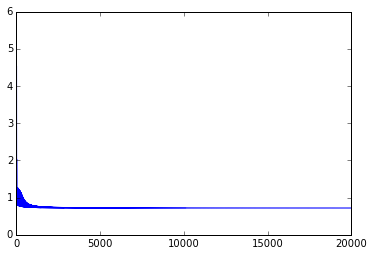

In [26]:
df.loss.plot()

In [27]:
def explode():
    for state in states:
        scores = state.scores
        yield [state.xs] + list(scores[0]) + list(scores[1])

scores = pd.DataFrame(list(explode()), columns=['xs', 's11', 's21', 's12', 's22'])

xs
(-50, 2)    Axes(0.125,0.125;0.775x0.775)
(50, 2)     Axes(0.125,0.125;0.775x0.775)
dtype: object

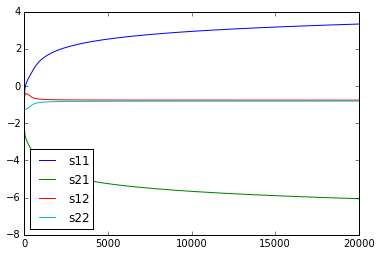

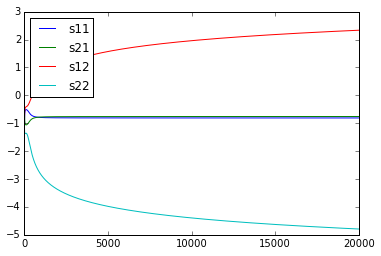

In [28]:
%matplotlib inline

scores.groupby('xs').plot()

## How Does the Model Evolve Over Time?

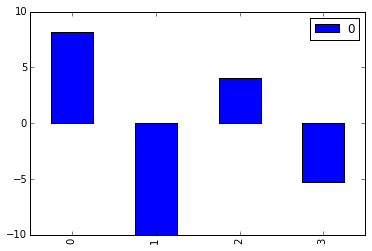

In [30]:
from ipywidgets import interact, fixed

@interact(xs_train=fixed(xs_train), ys_train=fixed(ys_train), iter_index=(0, len(states)-1), df=fixed(df))
def plot(xs_train, ys_train, iter_index, df):
    s = states[iter_index]
    
    rnn = RecurrentNeuralNetwork(xs_train=xs_train, ys_train=ys_train,
                                 whh=s.whh, bhh=s.bhh, wxh=s.wxh, bxh=s.bxh, ws=s.ws, bs=s.ws)
    rnn.batch_index = 1
    
    scores, predictions = rnn.predict(xs_train)
    
    axes = pd.DataFrame(list(scores[0]) + list(scores[1])).plot(kind='bar')
    axes.set_ylim(-10, 10)

In [17]:
rnn.predict(xs_train)

([array([ 2.80843333, -4.12558044]), array([ 2.80843479, -4.12558259])],
 [0, 0])

In [18]:
rnn.batch_index= 1

In [19]:
rnn.predict(xs_train)

([array([ 5.61686666, -8.25116088]), array([ 2.80853426, -4.12572872])],
 [0, 0])